# NON PUBLIE !!!

<p class="last_update">Dernière date de mise à jour du document : janvier 2023</p>

Les statistiques ci-dessous sont des données brutes issues de la base [POTE](https://www.casd.eu/source/declarations-dimpot-sur-le-revenu-des-foyers-fiscaux-formulaire-2042-et-annexes/) qui contient les revenus perçus en 2019 et déclarés en 2020.

Les fichiers POTE sont constitués des déclarations à l'impôt sur le revenu, y compris les corrections éventuelles par le déclarant ou les services fiscaux.  
Par contre,  les corrections issues des contrôles fiscaux, plus tardives, ne sont pas présentes.  
A noter que les services des impôts ne corrigent pas toutes les erreurs de saisie et encore moins celles qui n'impactent pas l'impôt, comme la date de naissance.  
C'est pourquoi la pyramide des ages fait apparaitre des personnes nées en 2019 ou avant 1900 alors que la doyenne des français est née en 1904.  
Autre exemple : Des personnes pacsées peuvent continuer de faire des déclarations séparées, elles apparaissent alors comme célibataires dans POTE, ou même séparées si elles ont fait ce choix ultérieurement.

L'impôt sur le revenu (IR) est un impôt direct calculé au niveau du foyer fiscal (ex. : un célibataire, ou un couple et ses enfants à charge). Il porte sur l’ensemble des revenus (salaires, revenus financiers, loyers perçus…) des personnes physiques composant le foyer. Les redevables de l’impôt sur le revenu sont les personnes ayant leur foyer fiscal en France, ou ceux domiciliés fiscalement à l’étranger mais touchant des revenus de source française. [→ Source : [Vie-publique.fr](https://www.vie-publique.fr/fiches/21885-quest-ce-que-limpot-sur-le-revenu)]  
Plusieurs foyers fiscaux peuvent exister dans un seul ménage ou une famille.  

**Comment lire ce document ?**

Ce document est un support de travail du service LexImpact, rendu public. Il n'a pas pour objectif d'expliquer de façon exhaustive le fonctionnement d'un dispositif.  
Les mémos regroupent la connaissance acquise par le service sur un dispositif lors de la conception et de la mise à jour des simulateurs. Cette connaissance concerne notamment :
- les ressources et références ;
- les agrégats ;
- le fonctionnement des dispositifs.

In [ ]:
# | hide
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# | hide
import json

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from leximpact_aggregates.aggregate import (
    AggregateManager,
    DataStructure,
    get_openfisca_variables,
)
from leximpact_common_python_libraries.config import Configuration
from tqdm import tqdm

from leximpact_prepare_data.scenario_tools.calib_and_copules import (
    copulas_to_array,
)

config = Configuration(project_folder="leximpact-prepare-data")

lex_color = "#A6A00C"

In [ ]:
# | hide
#!ls {config.get("CALIB")}/20220427-ExtractionAll/data/
year = "2020"
openfisca_variables = get_openfisca_variables()

In [ ]:
# | hide
data_path = config.get("CALIB") + "20220427-ExtractionAll/data/"
aggregates_path = "/mnt/data-out/leximpact-aggregates"

In [ ]:
# | hide
agm = AggregateManager(aggregates_path=aggregates_path)
agg_list = agm.list_aggregates()

In [ ]:
# | hide
agg_list["rfr"]

{'FileNames': ['/mnt/data-out/leximpact-aggregates/POTE/distribution_100/2021/rfr.yaml',
  '/mnt/data-out/leximpact-aggregates/POTE/distribution_100/2019/rfr.yaml',
  '/mnt/data-out/leximpact-aggregates/POTE/distribution_100/2020/rfr.yaml',
  '/mnt/data-out/leximpact-aggregates/POTE/distribution_10/2019/rfr.yaml',
  '/mnt/data-out/leximpact-aggregates/POTE/distribution_10/2020/rfr.yaml',
  '/mnt/data-out/leximpact-aggregates/POTE/mixed/rfr.yaml',
  '/mnt/data-out/leximpact-aggregates/POTE/copulas_100/rfr/2019/rfr.yaml',
  '/mnt/data-out/leximpact-aggregates/POTE/copulas_100/rfr/2020/rfr.yaml'],
 'DataStructure': ['distribution_100',
  'distribution_100',
  'distribution_100',
  'distribution_10',
  'distribution_10',
  'mixed',
  'copulas_100',
  'copulas_100']}

## Présentation des agrégats généraux de certaines variables

## Décile de RFR

In [ ]:
# | hide
# !ls /mnt/data-out/leximpact-aggregates

In [ ]:
# | hide
agmm = AggregateManager(aggregates_path=aggregates_path)
agmm.load_aggregate("POTE", "rfr", "2020")

In [ ]:
# | hide
for data in agmm.aggregate.data:
    if data.data_structure == DataStructure.DECILE and data.date == "2020":
        decile_rfr_2020 = data.values
df_decile_rfr_2020 = pd.DataFrame(decile_rfr_2020)
df_decile_rfr_2020.at[9, "upper_bound"] = 1_000_000_000
df_decile_rfr_2020["Décile"] = df_decile_rfr_2020.apply(
    lambda row: f"{int(row.quantile_index)+1} ⩽{row.upper_bound:,.0f}€/an", axis=1
)
# df_decile_rfr_2020

In [ ]:
# |echo: false
fig = px.bar(
    df_decile_rfr_2020,
    y="Décile",
    x="bucket_mean",
    title="Décile de RFR POTE 2020",
    orientation="h",
)
# _ = fig.update_xaxes(tickmode="linear")
_ = fig.update_traces(marker_color=lex_color)
_ = fig.update_layout(
    xaxis=dict(title="Moyenne de RFR"),
    yaxis=dict(
        title="Tranche de RFR", tickmode="linear", autorange="reversed"
    ),  # , rangemode="tozero"
)
fig.show()

_Lecture_ : Au dela d'un revenu fiscal de référence (RFR) de de 54 548 € un foyer fait parti des 10% des foyers les plus riches de France, qui ont un RFR moyen d'environs 100 000 €.

_A noter_ : Ici nous ne tenons pas compte de la situation du foyer, que le foyer comporte une personne célibataire ou un couple avec plusieurs enfants, c'est le RFR total qui est pris en compte.

## Chargement des sommes de variables

In [ ]:
# | hide
distribution_mixed = []
for k, v in agg_list.items():
    if DataStructure.MIXED in v["DataStructure"]:
        for f in v["FileNames"]:
            if "/POTE/" in f:
                distribution_mixed.append(k)
# Remove duplicate
distribution_mixed = [*set(distribution_mixed)]
assert len(distribution_mixed) > 10

In [ ]:
# | hide
agg_sum_list = []
for v in tqdm(distribution_mixed):
    if v == "age":
        continue
    agmm = AggregateManager(aggregates_path=aggregates_path)
    agmm.load_aggregate("POTE", v, "2020")
    for data in agmm.aggregate.data:
        if (
            data.date == "2020"
            and data.data_structure == DataStructure.DICT
            and data.values.get("sum")
        ):
            tmp_agg = {
                "var": v,
                "lib": agmm.aggregate.description,
                "sum": data.values["sum"],
            }
            agg_sum_list.append(tmp_agg)
assert len(agg_sum_list) > 0

100%|██████████| 136/136 [00:41<00:00,  3.32it/s]


In [ ]:
# | hide
df_sums = pd.DataFrame(agg_sum_list)
df_sums.sort_values("var", inplace=True)
df_sums["title"] = df_sums["lib"].str.slice(0, 32) + "(" + df_sums["var"] + ")"
df_sums.tail(2)

var                             lib      sum  \
58  z8sw  allocations chomage csg (6,2%)  1231739   
46  z8sx  allocations chomage csg (3,8%)   554142   

                                   title  
58  allocations chomage csg (6,2%)(z8sw)  
46  allocations chomage csg (3,8%)(z8sx)

In [ ]:
# | hide
# column_name.str.contains('s')
df_sums[df_sums.lib.str.contains("impot", na=False)]

var                                 lib          sum  \
54  mnipeg      impot net ou restitution nette  74924427322   
48  rnimeh   credit impot competitivite emploi      2170144   
32  rnirai  impot apres imputation restituable  69609137500   
37  rnirdu    impot avant imputation (ir seul)  74954399789   
63  rnirp8               impot net sur fichier   5689907719   

                                       title  
54    impot net ou restitution nette(mnipeg)  
48  credit impot competitivite emplo(rnimeh)  
32  impot apres imputation restituab(rnirai)  
37  impot avant imputation (ir seul)(rnirdu)  
63             impot net sur fichier(rnirp8)

In [ ]:
# | hide
# df_sums.query("var == 'impotnet'")
# df_sums.query("var == 'impot'")
# df_sums.query("var == 'rnirai'")
# df_sums.query("var == 'rnirdu'")
# df_sums.query("var == 'rnirgi'")
# df_sums.query("var == 'rnirp8'")

In [ ]:
# | hide


def plot_one_agg_on_many_var(df, agg_type="Somme en Euros", col="sum"):
    fig = px.bar(df, x=col, y="title", title=f"{agg_type} des variables POTE 2020")
    fig.update_layout(
        height=1200,
    )
    _ = fig.update_traces(marker_color=lex_color)
    _ = fig.update_layout(
        xaxis=dict(title=agg_type),
        yaxis=dict(title="Nom de la variable", tickmode="linear"),
    )
    # Ligne horizontale pour voir les valeurs même toute petite.
    _ = fig.update_layout(hovermode="y unified")
    return fig

In [ ]:
# |echo: false
plot_one_agg_on_many_var(df_sums)

## Graphique du nombre de foyer

In [ ]:
# | hide


# source : https://www.casd.eu/en/source/income-tax-declarations-for-tax-households-form-2042-and-appendices/?tab=1
libelles = {
    "agec": "ANNÉE DE NAISSANCE CONJOINT".lower(),
    "aged": "ANNÉE DE NAISSANCE DÉCLARANT".lower(),
    "clirpg": "ENFANTS INVALIDES".lower(),
    "mat": "Situation matrimoniale",
    "n": "NOMBRE D'ENFANTS MARIÉS RATTACHÉS".lower(),
    "nbefi": "NB TOTAL ENFANT A CHARGE I".lower(),
    "nbfoy": "NB PERSONNES DANS LE FOYER".lower(),
    "nbpldm": "INDICATEUR MARIé".lower(),
}

# Source :https://www.impots.gouv.fr/sites/default/files/formulaires/2042/2021/2042_3490.pdf
mat_lib = {
    "V": "Veuf(ve)",
    "C": "Célibataire",
    "O": "Pacsé(e)s",
    "D": "Divorcé(e)/séparé(e)",
    "M": "Marié(e)s",
}


def plot_bar(df, variable):
    var_lib = libelles.get(variable) if libelles.get(variable) else variable
    if variable == "mat":
        df = df.replace(mat_lib)
    fig = px.bar(
        df, x="count", y=variable, title=f"Répartition de la variable {var_lib}"
    )
    # _ = fig.update_xaxes(tickmode="linear")
    _ = fig.update_traces(marker_color=lex_color)
    _ = fig.update_layout(
        xaxis=dict(title="Nombre de foyers"),
        yaxis=dict(title=f"{var_lib}"),  # , rangemode="tozero"
    )
    return fig

In [ ]:
# | hide
# c = "n"
# df = pd.read_csv(f"20220224_ExtractAgg/sorties/count_2020_{c}.csv")
# df["count"].fillna(0, inplace=True)
# df = df.astype({c: "object"})

# df

In [ ]:
# | hide
# agm = AggregateManager()
# counts = ["agec", "aged", "mat", "n", "nbefi", "nbfoy", "nbpldm"]


data_tables = {}

counts = ["statut_marital", "nbpart", "nbf", "zn"]
for c in counts:
    agmm.load_aggregate("POTE", c, year, str(DataStructure.MIXED))
    # agmm.get_aggregate_value("POTE",c,year, "sum")

    # df = pd.read_csv(f"20220224_ExtractAgg/sorties/count_2019_{c}.csv")
    # if c in ["agec", "aged", "n"]:
    #     df.drop(df[df[c] == 0.0].index, inplace=True)
    # # if c in ["agec", "aged", "n", "nbefi", "nbfoy"]:
    # df = df.astype({c: "object"})
    # plot_bar(df, c)
    # list_agg = []
    for d in agmm.aggregate.data:
        if d.date == year:
            # print(d)
            df = pd.DataFrame({c: d.values.keys(), "count": d.values.values()})
            if c == "statut_marital":
                df = df.replace(mat_lib)
            data_tables[c] = df
# data_tables

In [ ]:
# | hide
# agmm.aggregate

In [ ]:
# |echo: false
for variable, df in data_tables.items():
    plot_bar(df, variable)

In [ ]:
# agmm.aggregate

In [ ]:
# agmm.get_aggregate_value("POTE",c,year,"sum")

## Graphique des distributions par décile

In [ ]:
# | hide
lex_color = "#A6A00C"


def set_dropdown(fig, tous_les_centiles, col_to_plot):
    """
    See https://plotly.com/python/dropdowns/
    """
    buttons = []
    for k, v in tous_les_centiles.items():
        f"Répartition de {v.get('lib')} ({k})"
        menu = dict(
            args=[
                {
                    "y": [v.get("data")[col_to_plot["col"]]],
                    "xaxis": {
                        "ticktext": [
                            f"{val:,.0f} €"
                            for val in v.get("data").lower_bound.to_list()
                        ]
                    },
                },
                {
                    "xaxis": {
                        "ticktext": [
                            f"{val:,.0f} €"
                            for val in v.get("data").lower_bound.to_list()
                        ]
                    }
                },
                # {"title": f"{v.get('lib')} ({k})"},
            ],
            label=f"{v.get('lib')} ({k})",
            method="update",
        )
        buttons.append(menu)

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=list(buttons),
                direction="down",
                # pad={"r": 10, "t": 10},
                showactive=True,
                x=0,
                xanchor="auto",
                y=1.1,
                yanchor="auto",
            ),
        ]
    )
    # Add annotation
    fig.update_layout(
        annotations=[
            dict(
                text="Variable à afficher:",
                showarrow=False,
                x=0,
                y=1.3,
                yref="paper",
                align="left",
            )
        ]
    )


def plot_calib(
    tous_les_centiles,
    col_to_plot={"col": "bucket_mean", "lib": "Moyenne"},
    x_title="Montant minimum du RFR",
):
    for k, v in tous_les_centiles.items():
        df = v.get("data")
        f"{col_to_plot.get('lib')} de {v.get('lib')} ({k})"
        break
    fig = px.line(
        df,
        x=df.index,
        y=col_to_plot["col"],
    )
    _ = fig.update_traces(
        text=df["bucket_count"],
        hovertemplate="Nombre de foyer : %{text}<br>",
    )
    """
    _ = fig.update_traces(
        text=df["bucket_count"],
        hovertemplate="Nombre de foyer : %{text}<br>"
        + "Frontière basse : %{x:,.0f} €<br>"
        + f"{col_to_plot.get('lib')}"
        + ": %{y:,.0} €<br>",
    )
    """
    # Update plot sizing
    fig.update_layout(
        width=700,
        height=700,
        autosize=False,
        margin=dict(t=10, b=0, l=0, r=0),
        template="plotly_white",
    )
    fig.update_layout(title_pad=dict(t=5, b=5, l=5, r=0))
    fig.update_scenes(aspectratio=dict(x=1, y=1, z=0.7), aspectmode="manual")
    set_dropdown(fig, tous_les_centiles, col_to_plot)
    # _ = fig.update_xaxes(tickmode="linear")
    _ = fig.update_traces(marker_color=lex_color)
    _ = fig.update_traces(mode="markers+lines")  # , hovertemplate=None
    _ = fig.update_layout(hovermode="x unified")
    _ = fig.update_layout(
        xaxis=dict(
            title=x_title,  # tickmode="linear",
            tickmode="array",
            tickvals=df.index,
            ticktext=[f"{val:,.0f} €" for val in df.lower_bound.to_list()],
        ),
        yaxis=dict(title=col_to_plot.get("lib") + " en Euros"),  # , rangemode="tozero"
    )

    return fig

In [ ]:
# hide
agg_decile_list = []
agg_deciles = {}
for v in distribution_mixed:
    if v == "age":
        continue
    agmm = AggregateManager(aggregates_path=aggregates_path)
    agmm.load_aggregate("POTE", v, "2019")
    for data in agmm.aggregate.data:
        if data.date == "2019" and data.data_structure == "decile":
            agg_deciles[v] = {
                "variable": v,
                "lib": agmm.aggregate.description,
                "data": pd.DataFrame(data.values),
            }
            agg_decile_list.append(tmp_agg)

In [ ]:
# | hide
agg_deciles["impot"]["data"]

quantile_index  lower_bound  upper_bound  bucket_count    bucket_sum  \
0               0  -10000000.0       -812.0       3926469 -1.074232e+10   
1               1       -812.0       -280.0       3926470 -1.946305e+09   
2               2       -280.0        -77.0       3926469 -6.516041e+08   
3               3        -77.0          0.0       3926470 -1.098282e+08   
4               4          0.0          0.0       3926470  0.000000e+00   
5               5          0.0          0.0       3926469  0.000000e+00   
6               6          0.0          0.0       3926470  0.000000e+00   
7               7          0.0        141.0       3926469  1.496016e+08   
8               8        141.0        683.0       3926470  1.417617e+09   
9               9        683.0  100000000.0       3926470  1.833454e+10   

   bucket_mean  bucket_stdev  
0 -2735.873358   6311.351596  
1  -495.688168    150.411918  
2  -165.951682     57.870201  
3   -27.971233     24.065077  
4     0.000000      0.000000  
5     0.000000      0.000000  
6     0.000000      0.000000  
7    38.100786     44.920207  
8   361.041180    153.555919  
9  4669.472210  81611.442887

In [ ]:
# |echo: false
fig = plot_calib(
    agg_deciles,
    col_to_plot={"col": "bucket_mean", "lib": "Moyenne du décile en Euros"},
    x_title="Montant minimum du décile",
)
fig.show()
# HTML(fig.to_html(include_plotlyjs="cdn"))

In [ ]:
fig.layout["annotations"]

(layout.Annotation({
     'align': 'left', 'showarrow': False, 'text': 'Variable à afficher:', 'x': 0, 'y': 1.3, 'yref': 'paper'
 }),)

## Graphique des distributions par quantiles variables

In [ ]:
# hide
distribution_10_agg = []
for k, v in agg_list.items():
    # print(v)
    if DataStructure.DISTRIBUTION_10 in v["DataStructure"]:
        distribution_10_agg.append(k)
assert len(distribution_10_agg) > 10
# distribution_10_agg
distribution_10_agg.sort()

In [ ]:
# hide
#!ls ../../../leximpact-aggregates/aggregates/POTE/distribution_10/2019/z8uy.yaml
#!cat ../../../leximpact-aggregates/aggregates/POTE/distribution_10/2019/z8uy.yaml

In [ ]:
# hide
#!ls {data_path}CalibPote-10-2019*

In [ ]:
# hide
# distribution_10_agg

In [ ]:
# hide
# agm.load_aggregate("POTE", "rfr", "2020", str(DataStructure.DISTRIBUTION_10))
# agm.aggregate.description
# agm.load_aggregate("POTE", "rfr", "2020", str(DataStructure.MIXED))
# agm.aggregate.description

In [ ]:
# !ls /mnt/data-out/leximpact-aggregates/POTE/mixed/

In [ ]:
# hide
tous_les_centiles = {}
max_line_len = 128
for var in distribution_10_agg:
    if var in ["eff_3112"]:
        break
    agm.load_aggregate("POTE", var, "2020", str(DataStructure.DISTRIBUTION_10))
    data = agm.aggregate.data[-1].values
    df = pd.DataFrame(data)
    label = ""
    if (
        isinstance(agm.aggregate.description, str)
        and len(agm.aggregate.description) > 1
    ):
        label = agm.aggregate.description[:max_line_len]
    if openfisca_variables.get(agm.aggregate.source_variable) and openfisca_variables[
        var
    ].get("label"):
        label = openfisca_variables[var]["label"][:max_line_len]
    tous_les_centiles[var] = {
        "variable": var,
        "lib": label,
        "data": df,
    }

In [ ]:
# distribution_10_agg

In [ ]:
# | hide
# data

In [ ]:
# | hide
# df = df.T
# df

In [ ]:
# |echo: false


def plot_bar_border(df, var, column: str = "bucket_mean"):
    df["Décile"] = df.apply(lambda row: f">{row.lower_bound:,.0f}€/an", axis=1)
    fig = px.bar(
        df,
        y="Décile",
        x=column,
        title=f"Distribution de {var}",
        orientation="h",
    )
    if "mean" in column:
        ytitle = f"Moyenne de {var}"
    if "mean_without_zero" in column:
        ytitle = f"Moyenne de {var} des foyers où {var} est > 0"
    # _ = fig.update_xaxes(tickmode="linear")
    _ = fig.update_traces(marker_color=lex_color)
    _ = fig.update_layout(
        xaxis=dict(title=ytitle),
        yaxis=dict(
            title=f"Tranche de {var}", tickmode="linear", autorange="reversed"
        ),  # , rangemode="tozero"
    )
    return fig


for var, data in tous_les_centiles.items():
    df_decile = data["data"]
    if data.get("lib"):
        var = data.get("lib")
    fig = plot_bar_border(df_decile, var)
    fig.show()

In [ ]:
# | hide
# c = "n"
# df = pd.read_csv(f"20220224_ExtractAgg/sorties/count_2019_{c}.datav")
# df["count"].fillna(0, inplace=True)
# df = df.astype({c: "object"})

# df

## Graphique des distributions par quantiles

In [ ]:
# | hide
distribution_10_agg = []
for k, v in agg_list.items():
    if DataStructure.DISTRIBUTION_10 in v["DataStructure"]:
        distribution_10_agg.append(k)
assert len(distribution_10_agg) > 10
# distribution_10_agg
distribution_10_agg.sort()

In [ ]:
# | hide
#!ls ../../../leximpact-aggregates/aggregates/POTE/distribution_10/2019/z8uy.yaml
#!cat ../../../leximpact-aggregates/aggregates/POTE/distribution_10/2019/z8uy.yaml

In [ ]:
# | hide
#!ls {data_path}CalibPote-10-2019*

In [ ]:
# | hide
# distribution_10_agg

In [ ]:
# | hide
# agm.load_aggregate("POTE", "rfr", "2019", str(DataStructure.DISTRIBUTION_10))
# agm.aggregate.description
# agm.load_aggregate("POTE", "rfr", "2019", str(DataStructure.MIXED))
# agm.aggregate.description

In [ ]:
# | hide
# openfisca_variables.get('f4ba')

In [ ]:
# | hide
# agm.aggregate

In [ ]:
# | hide
tous_les_centiles = {}
max_line_len = 128
for var in distribution_10_agg:
    if var in ["eff_3112"]:
        break
    agm.load_aggregate("POTE", var, year, str(DataStructure.DISTRIBUTION_10))
    data = agm.aggregate.data[-1].values
    df = pd.DataFrame(data)
    label = ""
    if (
        isinstance(agm.aggregate.description, str)
        and len(agm.aggregate.description) > 1
    ):
        label = agm.aggregate.description[:max_line_len]
    if openfisca_variables.get(agm.aggregate.source_variable) and openfisca_variables[
        var
    ].get("label"):
        label = openfisca_variables[var]["label"][:max_line_len]
    tous_les_centiles[var] = {
        "variable": var,
        "lib": label,
        "data": df,
    }

In [ ]:
# | hide
data = agm.aggregate.data[-1].values
df = pd.DataFrame(data)
df

lower_bound  upper_bound  bucket_count  bucket_sum    bucket_mean  \
0          0.0        116.0      39818172         0.0       0.000000   
1        116.0       9078.5            13     51392.0    3953.230769   
2       9078.5      36865.5            14    293680.0   20977.142857   
3      36865.5      88124.5            14    802357.0   57311.214286   
4      88124.5    1000000.0            14   2090766.0  149340.428571   

   bucket_stdev  count_above_upper_bound  sum_above_upper_bound  \
0      0.000000                       55              3238195.0   
1   2416.507816                       42              3186803.0   
2   8691.701133                       28              2893123.0   
3  16890.034873                       14              2090766.0   
4  56164.173623                        0                    0.0   

   ratio_count_above_upper_bound  mean_above_upper_bound  
0                   1.381277e-06            58876.272727  
1                   1.054793e-06            75876.261905  
2                   7.031955e-07           103325.821429  
3                   3.515978e-07           149340.428571  
4                   0.000000e+00                0.000000

### Moyenne par quantile

In [ ]:
# |echo: false
fig = plot_calib(tous_les_centiles)
fig.show()

### Somme par quantile

In [ ]:
# |echo: false
fig = plot_calib(tous_les_centiles, col_to_plot={"col": "bucket_sum", "lib": "Somme"})
# HTML(fig.to_html(include_plotlyjs="cdn"))
fig.show()

### Distribution bi-variée par déciles de RFR puis par statistiques de la variable étudiée

In [ ]:
# | hide
decile_rfr_agg = []
for k, v in agg_list.items():
    if DataStructure.MIXED in v["DataStructure"]:
        decile_rfr_agg.append(k)
assert len(decile_rfr_agg) > 10
# distribution_10_agg
decile_rfr_agg.sort()

In [ ]:
# | hide
deciles_rfr = {}
for var in tqdm(decile_rfr_agg):
    try:
        agm.load_aggregate("POTE", var, year, str(DataStructure.DECILE_RFR))
    except FileNotFoundError:
        # print(e)
        continue
    for data in agm.aggregate.data:
        if data.data_structure == "decile_rfr_10":
            # print(f'DECILE_RFR pour {var} !')
            data_values = data.values
            break
    else:
        # print(f'Pas de décile de RFR pour {var}')
        continue
    # df = pd.DataFrame(data)
    label = ""
    if (
        isinstance(agm.aggregate.description, str)
        and len(agm.aggregate.description) > 1
    ):
        label = agm.aggregate.description[:max_line_len]
    if openfisca_variables.get(agm.aggregate.source_variable) and openfisca_variables[
        var
    ].get("label"):
        label = openfisca_variables[var]["label"][:max_line_len]
    deciles_rfr[var] = {
        "variable": var,
        "lib": label,
        "data": data_values,
    }
# deciles_rfr

100%|██████████| 157/157 [00:42<00:00,  3.66it/s]


In [ ]:
# | hide


def decile_rfr_to_df(deciles_rfr_data):
    decile_rfr_var = {
        "lower_bound": [],
        "mean_with_zero": [],
        "mean_without_zero": [],
        "zeros": [],
        "count": [],
    }
    for cop in deciles_rfr_data:
        # decile_rfr_var["Décile"].append(f'RFR > {cop["lower_bound"]} €')
        decile_rfr_var["lower_bound"].append(cop["lower_bound"])
        decile_rfr_var["mean_without_zero"].append(cop["buckets"][-1]["bucket_mean"])
        decile_rfr_var["mean_with_zero"].append(
            cop["buckets"][-1]["bucket_sum"] / cop["count"]
        )
        decile_rfr_var["zeros"].append(cop["count_zero"])
        decile_rfr_var["count"].append(cop["count"])
    df = pd.DataFrame(decile_rfr_var)
    return df

In [ ]:
# | hide
var

'zp'

In [ ]:
# |echo: false
for var, v in deciles_rfr.items():
    df = decile_rfr_to_df(v["data"])
    if v.get("lib"):
        var = v.get("lib")
    plot_bar_border(df, var, "mean_with_zero")
    plot_bar_border(df, var, "mean_without_zero")

In [ ]:
# | hide
decile_rfr_to_df(deciles_rfr["impot"]["data"])
deciles_rfr["impot"]["data"][0]

KeyError: 'impot'

In [ ]:
# | hide
decile_rfr_to_df(deciles_rfr["irpp_economique"]["data"])
deciles_rfr["irpp_economique"]["data"][0]

lower_bound  mean_with_zero  mean_without_zero    zeros    count
0          0.0        7.938573        1168.360192  3954767  3981822
1       2264.0        9.344393         570.128390  3916561  3981823
2       8816.0        6.010562         474.437407  3931378  3981823
3      12854.0       27.112300         107.953220  2981793  3981822
4      16199.0      237.703126         409.985886  1673227  3981823
5      19450.0      535.561422         828.604884  1408207  3981823
6      23865.0      896.113864        1446.657942  1515333  3981822
7      30112.0     1497.203792        1957.869967   936881  3981823
8      38713.0     2669.100478        2947.418921   375995  3981823
9      54548.0    12968.195610       13465.873398   147162  3981823

ordereddict([('lower_bound', 0.0), ('upper_bound', 2264.0), ('count', 3981822), ('count_zero', 3954767), ('count_nonzero', 27055), ('buckets', [ordereddict([('lower_bound', 0), ('upper_bound', 0.5), ('bucket_count', 3954767), ('bucket_sum', 0), ('bucket_mean', 0), ('bucket_stdev', 0), ('count_above_upper_bound', 27055), ('sum_above_upper_bound', 31609985.0), ('ratio_count_above_upper_bound', 0.006794628187799454), ('mean_above_upper_bound', 1168.3601922010719)]), ordereddict([('lower_bound', 0.5), ('upper_bound', 10000000), ('bucket_count', 27055), ('bucket_sum', 31609985.0), ('bucket_mean', 1168.3601922010719), ('bucket_stdev', 17873.10253935524), ('count_above_upper_bound', 0), ('sum_above_upper_bound', 0), ('ratio_count_above_upper_bound', 0), ('mean_above_upper_bound', 0)])])])

In [ ]:
# | hide
agm.aggregate

Aggregate(description='sitfam : case p de la 2042', short_name='', openfisca_variable='', source_variable='zp', unit='foyer', perimeter=Perimeter(entity='foyer', period='year', geographic='France entière'), label_of_keys='', data=[Data(reference=[Reference(title='POTE 2020 (DGFIP)', href='https://www.casd.eu/source/declarations-dimpot-sur-le-revenu-des-foyers-fiscaux-formulaire-2042-et-annexes/')], date='2020', data_structure='dict', extraction_date='2022-09-09', values=ordereddict([('0', 38579884.0), ('P', 1238343.0)])), Data(reference=[Reference(title='POTE 2019 (DGFIP)', href='https://www.casd.eu/source/declarations-dimpot-sur-le-revenu-des-foyers-fiscaux-formulaire-2042-et-annexes/')], date='2019', data_structure='dict', extraction_date='2022-05-31', values=ordereddict([('0', 38046578.0), ('P', 1218118.0)]))])

In [ ]:
# | hide
tous_les_centiles.keys()

dict_keys(['assiette_csg_plus_values', 'assiette_csg_revenus_capital', 'chomage_et_indemnites', 'cics'])

## Distribution bi-variée par quantiles de RFR puis par quantiles de la variable étudiée

### Précision sur les chiffres du chômage dans POTE

La valeur `chomage_et_indemnites` est constiué de la somme des cases suivantes des déclarations d'impôt:
- 8sw : Allocations chômage CSG (6,2%) - [Allocations de chômage de source étrangère](https://www.impots.gouv.fr/sites/default/files/formulaires/2041-gg/2020/2041-gg_3081.pdf)
- 8sx : Allocations chômage CSG (3,8%) - [Allocations de chômage de source étrangère](https://www.impots.gouv.fr/sites/default/files/formulaires/2041-gg/2020/2041-gg_3081.pdf)
- 1ap : [Revenus remplacement](https://simulateur-ir-ifi.impots.gouv.fr/calcul_impot/2014/aides/salaires.htm) - Déclarant 1
- 1bp : [Revenus remplacement](https://simulateur-ir-ifi.impots.gouv.fr/calcul_impot/2014/aides/salaires.htm) - Déclarant 2

L'allocation chômage est plafonnée à 256,96 € brut par jour. Soit  256,96 € * 365 = 93 790,4 € par an. [source](https://www.unedic.org/indemnisation/vos-questions-sur-indemnisation-assurance-chomage/comment-est-calculee-mon-allocation-chomage)

Il y a aussi les indemnités d'élus dans ces cases. Le Président de la République reçoit la plus élevée, avec 182 445,70 € bruts annuels [source](https://fr.wikipedia.org/wiki/R%C3%A9mun%C3%A9ration_des_acteurs_institutionnels_en_France)

Mais également certaines pré-retraites.

In [ ]:
# | hide
# fig.to_dict

In [ ]:
# | hide
# !cd ../../../leximpact-aggregates/aggregates/POTE/copulas_100/2019/ && ls *.yaml
#!ls {data_path}/Cop*

In [ ]:
# | hide
#     # Pour assiette de CSG
#     df["revenus_capitaux_prelevement_bareme"] = df.Z2ch
#     df["revenus_capitaux_prelevement_liberatoire"] = df.Z2dh
#     df["revenus_capitaux_prelevement_forfaitaire_unique_ir"] = df.Z2dc + df.Z2tr

#     df["rente_viagere_titre_onereux_net"] = df.Z1cw + df.Z1dw
#     # Micro-foncier : on applique l'abattement de 30%
#     df["revenu_categoriel_foncier"] = (
#         df.Z4ba + (df.Z4be * 0.7) - (df.Z4bb + df.Z4bc + df.Z4bd)
#     )
#     # df['rev_categ_foncier4ba']=df.Z4ba
#     df["assiette_csg_plus_values"] = df.Z3vg + df.Z3ua + df.Z3vz
#     df["assiette_csg_revenus_capital"] = (
#         df["revenus_capitaux_prelevement_bareme"]
#         + df["revenus_capitaux_prelevement_liberatoire"]
#         + df["revenus_capitaux_prelevement_forfaitaire_unique_ir"]
#         + df["rente_viagere_titre_onereux_net"]
#         + df["revenu_categoriel_foncier"]
#         + df["assiette_csg_plus_values"]
#     )

#     # Autres
#     df["retraites"] = df.Z1as + df.Z1bs + df.MNIMQG
#     df[
#         "pre_retraites_etranger"
#     ] = df.Z8sc  # Attention, seulement de l'étranger, sinon c'est df.Z1ap + df.Z1bp

#     df["chomage_et_indemnites"] = df.Z8sw + df.Z8sx + df.Z1ap + df.Z1bp
#     df["rev_salaire"] = df.Z1aj + df.Z1bj + df.Z1cj

In [ ]:
# | hide


# with open(data_path + "CopulePote-100-2019-impotnet.json") as f:
with open(data_path + "CopulePote-100-2019-chomage_et_indemnites.json") as f:
    # with open(data_path + "CopulePote-100-2019-retraites.json") as f:
    data = json.load(f)

In [ ]:
# | hide
copulas_2d = copulas_to_array(data["copules"])

In [ ]:
# | hide
# data["copules"][-1]

In [ ]:
# | hide
copulas_2d["array"][1][1]

21.9937106918239

In [ ]:
# | hide
tab2d = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4],
    [],
]

tab2d = copulas_2d["array"].copy()

min_len = 1e15
max_len = 0
for x in tab2d:
    min_len = min(len(x), min_len)
    max_len = max(len(x), max_len)
print(min_len, max_len)
if min_len != max_len:
    for i, x in enumerate(tab2d):
        missing_cell = max_len - len(x)
        if missing_cell > 0:
            # On ajoute des 0 pour les cases manquantes,
            # en début de ligne
            if len(x) > 0:
                tab2d[i] = [0 for i in range(missing_cell)] + x
            else:
                tab2d[i] = [0 for i in range(missing_cell)]

1 103


In [ ]:
# | hide
copulas_2d["array"][-1]
tab2d[-1][-10:]
len(tab2d[-20])
len(tab2d[-1])

[[]]

[0, 0, 0, 0, 0, 0, 0, 0, 0, []]

103

103

/home/jupyter-benoit/leximpact-prepare-data/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



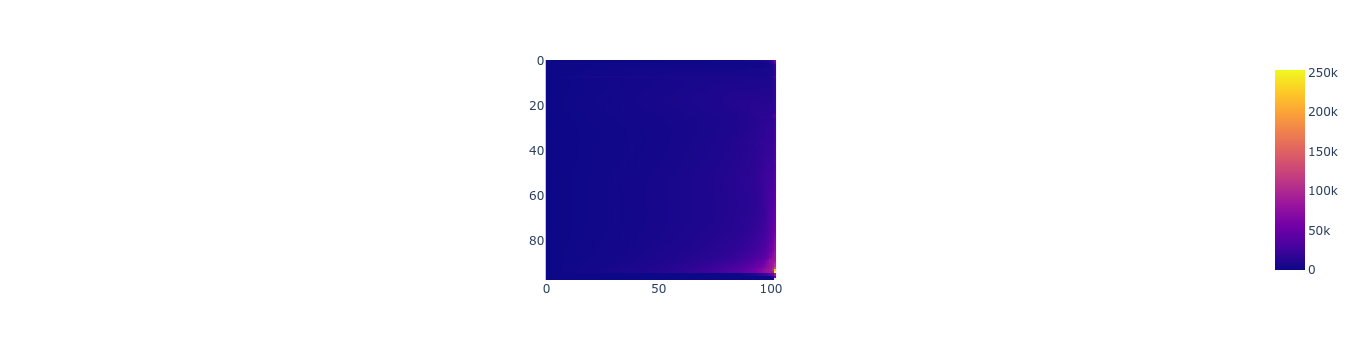

In [ ]:
# | hide
fig = px.imshow(tab2d)
fig.show()

In [ ]:
# | hide
tab2d_sans_riche = tab2d[10:-11]

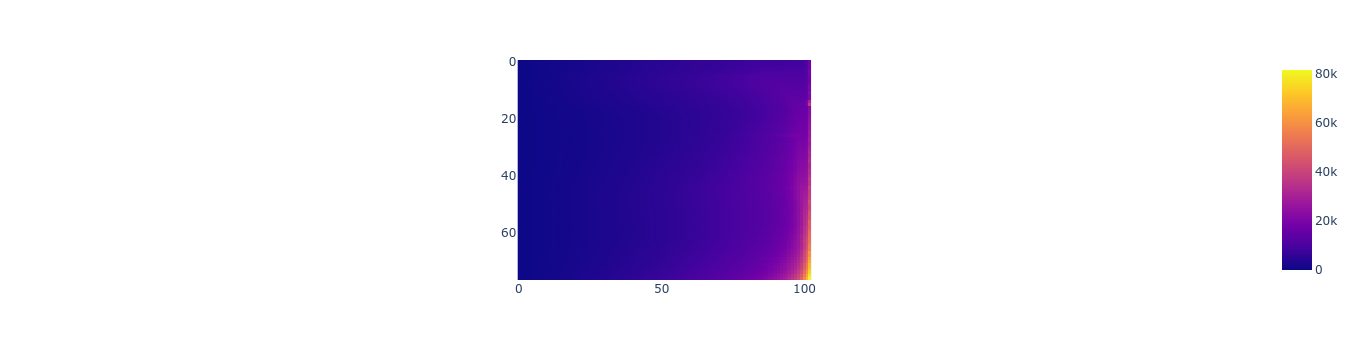

In [ ]:
# | hide
fig = px.imshow(tab2d_sans_riche)
fig.show()

In [ ]:
# | hide_input
# VOIR https://plotly.com/python/3d-surface-plots/
fig = go.Figure(data=[go.Surface(z=tab2d)])

_ = fig.update_layout(
    title="Copule de la moyenne de chômage (ou indemnité) par RFR",
    autosize=False,
    width=700,
    height=700,
    # margin=dict(l=65, r=50, b=65, t=90)
)
_ = fig.update_traces(
    contours_z=dict(
        show=True, usecolormap=True, highlightcolor="limegreen", project_z=True
    )
)
_ = fig.update_layout(
    scene=dict(
        xaxis=dict(title="Tranche de Chômage par tranche de RFR"),
        yaxis=dict(title="Tranche de RFR"),
        zaxis=dict(title="Montant en €"),
    ),
)

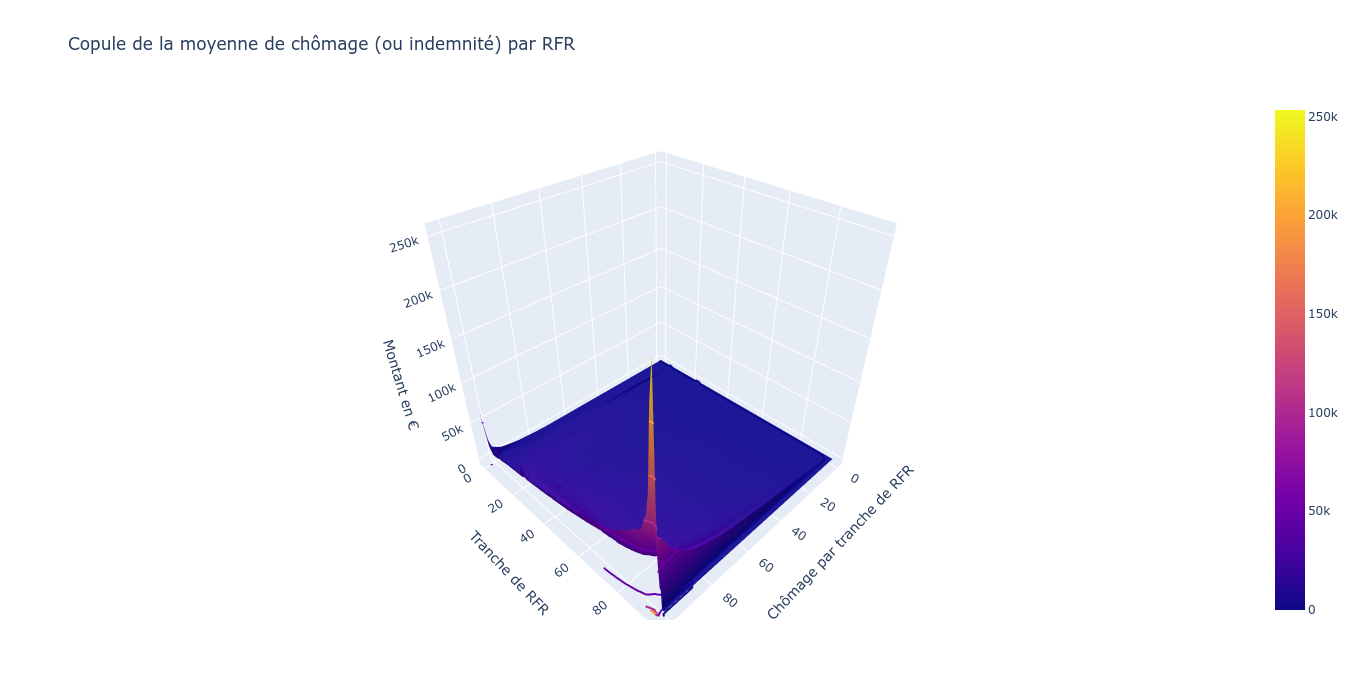

In [ ]:
# |echo: false
fig.show()